
##Import the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import keras
import keras.utils
from keras import utils as np_utils

import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
#from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


## Downloading the Data from Kaggle

Here we connect to kaggle using kaggle.json to download the relevant dataset from kaggle directly into colab. Please make sure to generate and save kaggle.json prior to running this cell. As this will prompt you to upload kaggle.json file.


In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"udhavrana086","key":"477e21135d9d1506c9ed7dc5f430ac42"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                     Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16          13423        361  1.0              
chitrakumari25/corona-virus-latest-data-2023              Corona virus latest data 2023                      10KB  2023-04-29 16:00:51           1073         29  1.0              
utkarshx27/starbucks-nutrition                            Starbucks Nutrition Facts                           2KB  2023-05-10 05:42:59            563         22  1.0              
utkarshx27/monthly-transportation-statistics              Monthly Transportation Statistics         

In [ ]:
! kaggle datasets download sunnysai12345/news-summary

100% 19.8M/19.8M [00:02<00:00, 15.7MB/s]
100% 19.8M/19.8M [00:02<00:00, 9.99MB/s]


In [ ]:
! unzip news-summary.zip

Archive:  news-summary.zip
  inflating: news_summary.csv        
  inflating: news_summary_more.csv   


# Preprocessing of Data

In [ ]:
data = pd.read_csv("/content/news_summary_more.csv",  encoding='latin-1')
data_more = pd.read_csv("/content/news_summary.csv",  encoding='latin-1')
data.shape

(98401, 2)

In [ ]:
data_more.shape

(4514, 6)

In [ ]:
data

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhattisgarh,"A CRPF jawan was on Tuesday axed to death with sharp-edged weapons by Maoists at a local village fair in Chhattisgarh's insurgency-hit Bijapur district. As per preliminary information, Maoists att..."
98397,First song from Sonakshi Sinha's 'Noor' titled 'Uff Yeh' out,"'Uff Yeh', the first song from the Sonakshi Sinha starrer upcoming drama film 'Noor' has been released. The song has been composed by Amaal Mallik with vocals by Armaan Malik and lyrics by Manoj M..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development. Michael B Jordan will reportedly play the lead role in the film. Screenwriter Zak Penn is in ta..."
98399,Snoop Dogg aims gun at clown dressed as Trump in new video,A new music video shows rapper Snoop Dogg aiming a toy gun at a clown character parodying US President Donald Trump. The video also shows a TV airing a news conference with the headline 'Ronald Kl...


In [ ]:
data_more

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking,http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced-labour-trafficking-traning-hotel-staff/1/1017210.html?utm_source=inshorts&u...,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."
...,...,...,...,...,...,...
4509,Mansha Mahajan,"24 Feb 2017,Friday",Rasna seeking ?250 cr revenue from snack category: Chairman,http://indiatoday.intoday.in/story/rasna-eyes-rs-250-cr-revenue-from-snack-category/1/890034.html,"Fruit juice concentrate maker Rasna is eyeing a revenue of ?250 crore in the next three years from the snack category, Chairman Piruz Khambatta said. Rasna, which has presence in the sweet snack c...","Mumbai, Feb 23 (PTI) Fruit juice co

### Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [ ]:
data.shape

(98360, 2)

We will use dictionary for expanding the contractions:

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#call the function
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [ ]:
data

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhattisgarh,"A CRPF jawan was on Tuesday axed to death with sharp-edged weapons by Maoists at a local village fair in Chhattisgarh's insurgency-hit Bijapur district. As per preliminary information, Maoists att..."
98397,First song from Sonakshi Sinha's 'Noor' titled 'Uff Yeh' out,"'Uff Yeh', the first song from the Sonakshi Sinha starrer upcoming drama film 'Noor' has been released. The song has been composed by Amaal Mallik with vocals by Armaan Malik and lyrics by Manoj M..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development. Michael B Jordan will reportedly play the lead role in the film. Screenwriter Zak Penn is in ta..."
98399,Snoop Dogg aims gun at clown dressed as Trump in new video,A new music video shows rapper Snoop Dogg aiming a toy gun at a clown character parodying US President Donald Trump. The video also shows a TV airing a news conference with the headline 'Ronald Kl...


Let us look at the first five preprocessed reviews

In [ ]:
cleaned_text[:5]  

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [ ]:
#call the function
cleaned_summary = []
for t in data['headlines']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [ ]:
data

,headlines,text,cleaned_text,cleaned_summary
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...,upgrad learner switches to career in ml al with salary hike
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bi...,delhi techie wins free food from swiggy for one year on cred
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,new zealand end rohit sharma led india match winning streak
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,aegon life iterm insurance plan helps customers save tax
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I...",speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment add...,have known hirani for yrs what if metoo claims are not true sonam
...,...,...,...,...
98396,CRPF jawan axed to death by Maoists in Chhattisgarh,"A CRPF jawan was on Tuesday axed to death with sharp-edged weapons by Maoists at a local village fair in Chhattisgarh's insurgency-hit Bijapur district. As per preliminary information, Maoists att...",crpf jawan tuesday axed death sharp edged weapons maoists local village fair chhattisgarh insurgency hit bijapur district per preliminary information maoists attacked jawan gone visit fair along f...,crpf jawan axed to death by maoists in chhattisgarh
98397,First song from Sonakshi Sinha's 'Noor' titled 'Uff Yeh' out,"'Uff Yeh', the first song from the Sonakshi Sinha starrer upcoming drama film 'Noor' has been released. The song has been composed by Amaal Mallik with vocals by Armaan Malik and lyrics by Manoj M...",uff yeh first song sonakshi sinha starrer upcoming drama film noor released song composed amaal mallik vocals armaan malik lyrics manoj muntashir sonakshi seen portraying pakistani journalist writ...,first song from sonakshi sinha noor titled uff yeh out
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development. Michael B Jordan will reportedly play the lead role in the film. Screenwriter Zak Penn is in ta...",acco

In [ ]:
cleaned_summary[:10]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam',
 'rahat fateh ali khan denies getting notice for smuggling currency',
 'india get all out for their lowest odi total in new zealand',
 'govt directs alok verma to join work day before his retirement',
 'called pm modi sir times to satisfy his ego andhra cm',
 'cong wins ramgarh bypoll in rajasthan takes total to seats']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

### Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# Analyzing and Preparing the Data

We will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text to fix the maximum length of the sequence:

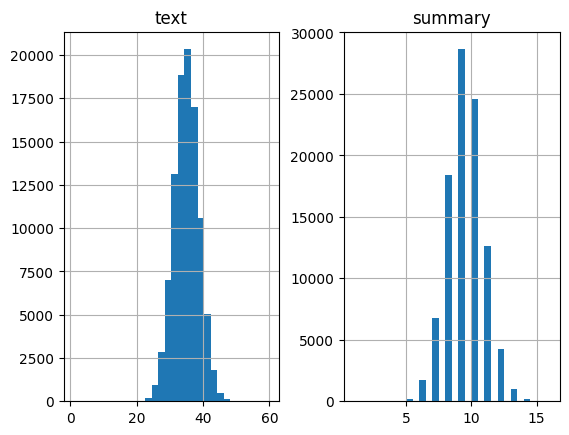

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=12):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9880337535583571


We observe that 98.8% of the summaries have length below 12. So, we can fix maximum length of summary to 12.

Let us fix the maximum length of review to 42

In [ ]:
max_text_len=42
max_summary_len=12

Select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

We have to add the **START** and **END** special tokens at the beginning and end of the summary which does not appear anywhere in the summary.



In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

### Splitting the Data
We split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and 10% as the validation set.

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
x_tr

array(['madrassas uttar pradesh bareilly defied state government order hoisting tricolour singing national anthem independence day may face action national security act bareilly divisional commissioner pv jaganmohan said adding madrassas across state followed government order said bareilly madrassas law',
       'pakistani doctor shakil afridi helped locate former al qaeda chief osama bin laden held jail nearly years arrested ties militant group us forces killed bin laden pakistan accused afridi running fake vaccination programme collected dna samples confirm bin laden identity',
       'new york based startup wearable made pair yoga pants called nadi guides user yoga vibrates help embedded technology correct body posture using vibrational feedback pants encourage users gentle pulses around hips knees ankles dedicated app shows users yoga experience level',
       ...,
       'architect balkrishna vithaldas doshi become first indian win pritzker prize highest award architecture calling

In [ ]:
y_tr

array(['sostok up madrassas which did not unfurl tricolour may face action eostok',
       'sostok pak doctor who helped find bin laden held in jail since eostok',
       'sostok startup yoga pants vibrate to give correct posture eostok',
       ...,
       'sostok architect bv doshi becomes st indian to win pritzker prize eostok',
       'sostok astronomers detect the earliest stars of the universe eostok',
       'sostok mea denies kerala minister permission to attend china meet eostok'],
      dtype=object)

### Text Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. 

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords and its Coverage

We are taking the threshold of 4 for rare words. We will find proportion and total coverage of rare words in entire text


In [ ]:
x_tr

array(['madrassas uttar pradesh bareilly defied state government order hoisting tricolour singing national anthem independence day may face action national security act bareilly divisional commissioner pv jaganmohan said adding madrassas across state followed government order said bareilly madrassas law',
       'pakistani doctor shakil afridi helped locate former al qaeda chief osama bin laden held jail nearly years arrested ties militant group us forces killed bin laden pakistan accused afridi running fake vaccination programme collected dna samples confirm bin laden identity',
       'new york based startup wearable made pair yoga pants called nadi guides user yoga vibrates help embedded technology correct body posture using vibrational feedback pants encourage users gentle pulses around hips knees ankles dedicated app shows users yoga experience level',
       ...,
       'architect balkrishna vithaldas doshi become first indian win pritzker prize highest award architecture calling

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.2028011283102
Total Coverage of rare words: 2.0679543725417617


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_tr_seq

[[20128,
  162,
  61,
  6246,
  15890,
  21,
  7,
  241,
  12391,
  5942,
  2743,
  81,
  2719,
  1166,
  42,
  115,
  364,
  323,
  81,
  127,
  463,
  6246,
  9087,
  1701,
  3841,
  1,
  121,
  20128,
  236,
  21,
  936,
  7,
  241,
  1,
  6246,
  20128,
  234],
 [462,
  1500,
  22889,
  3180,
  889,
  5778,
  29,
  951,
  4431,
  46,
  7938,
  2544,
  5571,
  226,
  484,
  186,
  23,
  85,
  1984,
  1531,
  99,
  5,
  503,
  107,
  2544,
  5571,
  45,
  41,
  3180,
  1057,
  487,
  13899,
  982,
  1835,
  2477,
  3062,
  4857,
  2544,
  5571,
  2086],
 [25,
  829,
  38,
  114,
  7411,
  55,
  2433,
  1985,
  5627,
  65,
  16566,
  203,
  1985,
  27128,
  144,
  7610,
  209,
  3823,
  237,
  15335,
  156,
  4944,
  5627,
  3445,
  105,
  15891,
  9890,
  66,
  15892,
  8944,
  27129,
  3025,
  286,
  433,
  105,
  1985,
  1239,
  680],
 [11,
  899,
  105,
  5474,
  133,
  3428,
  1986,
  650,
  240,
  383,
  576,
  7056,
  2530,
  105,
  662,
  169,
  2206,
  1427,
  2055,
  240,
  

In [ ]:
x_voc

30497

In [ ]:
x_tr

array([[20128,   162,    61, ...,     0,     0,     0],
       [  462,  1500, 22889, ...,  2086,     0,     0],
       [   25,   829,    38, ...,     0,     0,     0],
       ...,
       [10713,  8810, 14896, ...,     0,     0,     0],
       [ 4040,  6968,    21, ...,     0,     0,     0],
       [  219,  1162,   608, ...,     0,     0,     0]], dtype=int32)

### Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

Here we are taking the threshold of 6 for rare words. We will find proportion and total coverage of rare words in entire text

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.74296484044973
Total Coverage of rare words: 3.987030893861561


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
print(y_voc)

10851


Here, I am deleting the rows that contain only **START** and **END** tokens because it will not be useful for training. 

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building


### Custom Attention Layer

We have to build custom attention layer because keras does not officially support attention layer. We will use third-party implementation of custom attention layer taken from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) 

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


We are building model with encoder-deocder architecture having global attention (bahadau attention model). 
- Encoder contains a **embedding** layer, followed by 3 stacked **LSTM** layers one after another.
- Decoder also contains a **embedding** layer followed by **LSTM** layers and a **Dense** layer.
- Global Attention layer is there which takes in encoder outputs and decoder outputs.
- Model is reasonably small to reduce traning time and it can easily summarize reviews which of max_length 50 


In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 500
embedding_dim=500

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# encode_outputs=attn_out
# decide_outputs=attn_states

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 500)      15248500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 42, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

We are using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 500)      15248500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 42, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

# Training the Model

We are using early stopping to monitor the validation loss metric. Our model will stop traning if the validation loss starts increasing.

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/news embedding 500/model/my_model.h5',custom_objects={"AttentionLayer":AttentionLayer})

OSError: ignored

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/new 0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es,cp_callback],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/30
334/334 [==============================] - ETA: 0s - loss: 6.0299
Epoch 1: saving model to /content/drive/MyDrive/new 0/cp.ckpt
334/334 [==============================] - 147s 394ms/step - loss: 6.0299 - val_loss: 5.5810
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 5.2580
Epoch 2: saving model to /content/drive/MyDrive/new 0/cp.ckpt
334/334 [==============================] - 107s 321ms/step - loss: 5.2580 - val_loss: 4.8920
Epoch 3/30
334/334 [==============================] - ETA: 0s - loss: 4.5259
Epoch 3: saving model to /content/drive/MyDrive/new 0/cp.ckpt
334/334 [==============================] - 105s 313ms/step - loss: 4.5259 - val_loss: 4.3061
Epoch 4/30
334/334 [==============================] - ETA: 0s - loss: 3.8704
Epoch 4: saving model to /content/drive/MyDrive/new 0/cp.ckpt
334/334 [==============================] - 105s 316ms/step - loss: 3.8704 - val_loss: 3.9093
Epoch 5/30
334/334 [==============================] - ETA: 0s - loss: 3.

### Plot of Training and Validation loss



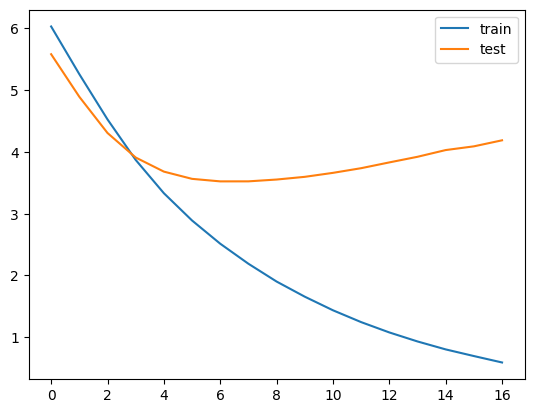

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 13 for 2 successive epochs. Hence, training is stopped at epoch 19.



In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summaries generated by the model:

In [ ]:
file1 = open("MyFile.txt","a")

In [ ]:
predicted = []
for i in range(40,80):
    print("News:",seq2text(x_tr[i]))
    file1.write("news:"+seq2text(x_tr[i])+"\n")
    print("Original information:",seq2summary(y_tr[i]))
    file1.write("Original information:"+seq2summary(y_tr[i])+"\n")
    print("Predicted information:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    file1.write("Predicted information:"+decode_sequence(x_tr[i].reshape(1,max_text_len))+"\n"+"\n")
    predicted.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

News: paypal rival wednesday saw valuation hit billion one europe biggest technology initial public offerings company revenue exceeded billion first time recorded net profit million period founded processes payments companies including facebook netflix ebay 
Original information: paypal rival value more than doubles at bn post ipo 
1/1 [==============================] - 0s 37ms/step
Predicted information:  paypal rival value more than doubles at bn
1/1 [==============================] - 0s 77ms/step


News: yuvraj singh venturing cricket acted punjabi movies child artiste performed cameos two punjabi movies putt de mehndi di yuvraj turns today player tournament award icc cricket world cup india defeating sri lanka final 
Original information: yuvraj singh acted in movies as child artiste 
1/1 [==============================] - 0s 74ms/step
Predicted information:  yuvraj singh acted in movies as child artiste
1/1 [==============================] - 0s 39ms/step


News: three people onboa

## Evaluation - BLEU Score


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
y_tr

array([[   1,   25,  352, ...,    2,    0,    0],
       [  57,  864,   44, ...,  223,  325,    2],
       [   1,   85, 1751, ...,    0,    0,    0],
       ...,
       [   1, 8114,  227, ...,    0,    0,    0],
       [   1, 2643, 2069, ...,    2,    0,    0],
       [   1, 3498,  311, ...,  504,    2,    0]], dtype=int32)

In [ ]:
information

[array([   1,   25,  352,  159,   10, 2771,   86,  301,  626,    2,    0,
           0], dtype=int32),
 array([  57,  864,   44, 1378,  627, 4378, 4138,  120,    4,  223,  325,
           2], dtype=int32),
 array([   1,   85, 1751, 4953,    3,  248, 7189,    2,    0,    0,    0,
           0], dtype=int32),
 array([   1,  155, 1638, 1035,  174,  144,  136, 2095,  444,    2,    0,
           0], dtype=int32),
 array([   1, 2721, 2540,  312, 1366,  361,    4, 5729,  129,    2,    0,
           0], dtype=int32),
 array([  65,   27,   20,  584,   35,    8, 9183,  907,  198,    4,   54,
           2], dtype=int32),
 array([   1,   46,    3,  228,  987,   14,  143, 9977,   22,   40,    2,
           0], dtype=int32),
 array([ 116,   24,  355,  797,  463,  810,  949,    7, 3828,    8,  828,
           2], dtype=int32),
 array([   1,  715, 2575, 4638, 1452,    6,  135, 4379,   62,    2,    0,
           0], dtype=int32),
 array([   1,    9,   24,   21,  177, 4139,  228,   17, 3227, 1152,    2,

In [ ]:
information = list(y_tr)
references = []
for i in range(len(information)):
    summ= seq2summary(information[i])
    ref = summ.split()
    references.append(ref)

In [ ]:
refs = []
smooth = SmoothingFunction().method4
sum=0
for i in range(40,80):
    refs.append(references[i])
    print(refs, predicted[i-40].split())
    print(sentence_bleu(refs, predicted[i-40].split(), weights=(0.25,0.25,0.25,0.25)))
    sum=sum+sentence_bleu(refs, predicted[i-40].split(), weights=(0.25,0.25,0.25,0.25))
    refs.remove(references[i])
print(sum/40)

[['paypal', 'rival', 'value', 'more', 'than', 'doubles', 'at', 'bn', 'post', 'ipo']] ['paypal', 'rival', 'value', 'more', 'than', 'doubles', 'at', 'bn']
0.7788007830714049
[['yuvraj', 'singh', 'acted', 'in', 'movies', 'as', 'child', 'artiste']] ['yuvraj', 'singh', 'acted', 'in', 'movies', 'as', 'child', 'artiste']
1.0
[['fly', 'from', 'cabin', 'get', 'stuck', 'in', 'helicopter', 'tail', 'die', 'in', 'crash']] ['three', 'people', 'killed', 'in', 'new', 'zealand', 'chopper', 'crash', 'in', 'russia']
1.2199981975731961e-231
[['was', 'not', 'selected', 'for', 'tamil', 'nadu', 'because', 'of', 'long', 'hair', 'vijay']] ['tamil', 'nadu', 'based', 'on', 'tamil', 'nadu', 'based', 'on', 'vijay']
5.396466934950335e-155
[['india', 'first', 'independence', 'movement', 'happened', 'years', 'ago']] ['india', 'first', 'independence', 'movement', 'happened', 'years', 'ago']
1.0
[['railways', 'to', 'not', 'seek', 'funds', 'from', 'next', 'year', 'budget']] ['railways', 'to', 'train', 'projects', 'over'

## Evaluation - ROGUE Score

In [ ]:
!pip install rouge_score
from rouge_score import rouge_scorer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=738920b389c03bf05efa2a725bcc2eb8e8660c787c0827f2c9febf796c909f7c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)


In [ ]:
sum=0;
for i in range(40,80):
    print(seq2summary(information[i]), predicted[i-40])
    print(scorer.score(seq2summary(information[i]), predicted[i-40]))
    # sum=sum+scorer.score(seq2summary(summaries[i]), predicted[i])
print(sum)    

paypal rival value more than doubles at bn post ipo   paypal rival value more than doubles at bn
{'rouge1': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889), 'rougeL': Score(precision=1.0, recall=0.8, fmeasure=0.888888888888889)}
yuvraj singh acted in movies as child artiste   yuvraj singh acted in movies as child artiste
{'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
fly from cabin get stuck in helicopter tail die in crash   three people killed in new zealand chopper crash in russia
{'rouge1': Score(precision=0.3, recall=0.2727272727272727, fmeasure=0.28571428571428564), 'rougeL': Score(precision=0.2, recall=0.18181818181818182, fmeasure=0.1904761904761905)}
was not selected for tamil nadu because of long hair vijay   tamil nadu based on tamil nadu based on vijay
{'rouge1': Score(precision=0.3333333333333333, recall=0.2727272727272727, fmeasure=0.3), 'rougeL': Score(precision=0.3333333333333333, recall=0

In [ ]:
model.save('/content/drive/MyDrive/new 0/model/my_model.h5') 

In [ ]:
information

[array([   1,   25,  352,  159,   10, 2771,   86,  301,  626,    2,    0,
           0], dtype=int32),
 array([  57,  864,   44, 1378,  627, 4378, 4138,  120,    4,  223,  325,
           2], dtype=int32),
 array([   1,   85, 1751, 4953,    3,  248, 7189,    2,    0,    0,    0,
           0], dtype=int32),
 array([   1,  155, 1638, 1035,  174,  144,  136, 2095,  444,    2,    0,
           0], dtype=int32),
 array([   1, 2721, 2540,  312, 1366,  361,    4, 5729,  129,    2,    0,
           0], dtype=int32),
 array([  65,   27,   20,  584,   35,    8, 9183,  907,  198,    4,   54,
           2], dtype=int32),
 array([   1,   46,    3,  228,  987,   14,  143, 9977,   22,   40,    2,
           0], dtype=int32),
 array([ 116,   24,  355,  797,  463,  810,  949,    7, 3828,    8,  828,
           2], dtype=int32),
 array([   1,  715, 2575, 4638, 1452,    6,  135, 4379,   62,    2,    0,
           0], dtype=int32),
 array([   1,    9,   24,   21,  177, 4139,  228,   17, 3227, 1152,    2,